# Coefficient Reloadable FIR Filter Hardware Design
This notebook demonstrates how to accelerate a function (FIR filter) from a processing system (PS) to programmable logic (PL), and how to reload FIR filter coefficients on a Zynq-7000 using PYNQ. First, input the voice signal. Then, realize the noise reduction of the voice signal in the PL, and then play the voice after noise reduction

## View audio signal information

In [1]:
from IPython.display import Audio as IPAudio
IPAudio("/home/xilinx/jupyter_notebooks/highpass_FIR/restaurant_sn15.wav")  #recording_0  test_recording

In [36]:
%matplotlib inline
import wave
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.fftpack import fft

wav_path = "/home/xilinx/jupyter_notebooks/highpass_FIR/restaurant_sn15.wav"

with wave.open(wav_path, 'r') as wav_file:
    raw_frames = wav_file.readframes(-1)
    num_frames = wav_file.getnframes()
    num_channels = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()



temp_buffer = np.empty((num_frames, num_channels, 4), dtype = np.uint8) #int8
raw_bytes = np.frombuffer(raw_frames, dtype=np.uint8)
temp_buffer[:, :, :sample_width] = raw_bytes.reshape(-1, num_channels, sample_width)
temp_buffer[:, :, sample_width:] = (temp_buffer[:, :, sample_width-1:sample_width] >> 7) * 1023
frames = temp_buffer.view('<i4').reshape(temp_buffer.shape[:-1])
#print(frames,temp_buffer)
print(num_frames,num_channels,sample_rate,sample_width,raw_bytes)    

21119 1 8000 2 [149 255  60 ...,   0  18   0]


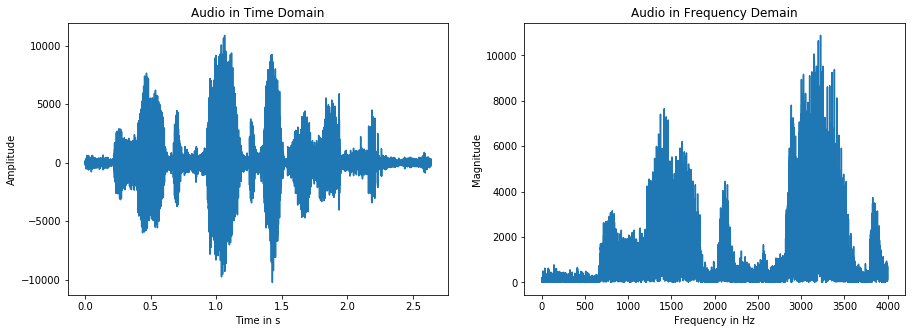

In [35]:
plt.figure(num=None, figsize=(15, 5))
plt.subplot(1,2,1)
plt.title('Audio in Time Domain')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
time_axis = np.arange(0, num_frames/sample_rate, 1/sample_rate)
plt.plot(time_axis, frames)
#plt.savefig('./time_domain_filter.jpg')
#plt.show()
plt.subplot(1,2,2)
plt.title('Audio in Frequency Demain')
plt.xlabel('Frequency in Hz')
plt.ylabel('Magnitude')
temp = fft(frames)
yf = temp[1:len(temp)//2]
#yf = temp[1:len(temp)]
xf = np.linspace(0.0, sample_rate/2, len(yf))
plt.plot(xf,abs(yf))
plt.savefig('./time_frequency_domain_start.jpg')
plt.show()

# Program FPGA

In [3]:
from pynq import Overlay

# Program PL + load drivers for hardware found in HWH
overlay = Overlay("/home/xilinx/jupyter_notebooks/highpass_FIR/fir_reload.bit")

## Load Drivers

In [4]:
from pynq.lib import AxiGPIO
from pynq import allocate

# Load FIR Data DMA
dma_fir_data = overlay.axi_dma_fir_data
# Load FIR Reload DMA
dma_fir_reload = overlay.axi_dma_reload
# Load FIR Config DMA
dma_fir_config = overlay.axi_dma_config

## paramater value

In [5]:
import numpy as np
import time
n=num_frames
T = n/num_frames
t = np.linspace(0,T,n,endpoint=False)
n_plot = 100

## Send Waveform to FIR Filter via DMA with initial coefficients

In [8]:
# Allocate physically contiguous buffers for direct register DMA
in_data_buffer = allocate(shape=(n,2),dtype=np.int32) #int32
print(in_data_buffer[:,:])
out_data_buffer = allocate(shape=(n,2),dtype=np.int32)

# Copy the samples to the input buffer
#for channel_index in range(num_channels):
#    samples = frames[:, channel_index]
#    samples = samples.astype(np.int32)
#    print(samples)
#    np.copyto(in_data_buffer[:, channel_index],samples)
samples = frames   
samples = samples.astype(np.int32)
np.copyto(in_data_buffer,samples)


#samples = samples.astype(np.int32)
#np.copyto(in_data_buffer,samples)
# Trigger the DMA and wait for the result
start_time = time.time()
dma_fir_data.sendchannel.transfer(in_data_buffer)
dma_fir_data.recvchannel.transfer(out_data_buffer)
dma_fir_data.sendchannel.wait()
dma_fir_data.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware FIR execution time: ',hw_exec_time,'s for ',T,'s signal')
#print('Hardware acceleration factor: ',sw_exec_time_lpf / hw_exec_time)
print("Berfore filtering")
print(in_data_buffer[:,:])
print("After filtering")
print(out_data_buffer[:,:])
out_data_buffer[:,:]=out_data_buffer[:,:]*300
out_data_buffer.close()



[[0 0]
 [0 0]
 [0 0]
 ..., 
 [0 0]
 [0 0]
 [0 0]]
Hardware FIR execution time:  0.003894329071044922 s for  1.0 s signal
Berfore filtering
[[-107 -107]
 [-196 -196]
 [-187 -187]
 ..., 
 [ 169  169]
 [  81   81]
 [  18   18]]
After filtering
[[0 0]
 [0 0]
 [0 0]
 ..., 
 [0 0]
 [0 0]
 [0 0]]


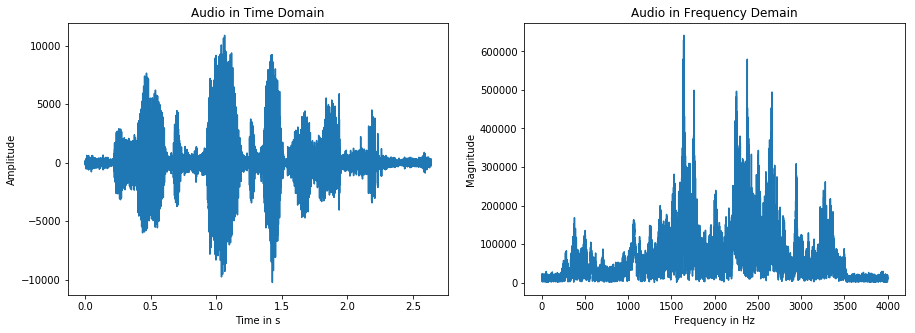

In [28]:
frames1 = out_data_buffer.view('<i4')

plt.figure(num=None, figsize=(15, 5))
plt.subplot(1,2,1)
plt.title('Audio in Time Domain')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
time_axis1 = np.arange(0, num_frames/sample_rate, 1/sample_rate)
plt.plot(time_axis1, frames[:, 0])
#plt.savefig('./time_domain_filter.jpg')
#plt.show()
plt.subplot(1,2,2)
plt.title('Audio in Frequency Demain')
plt.xlabel('Frequency in Hz')
plt.ylabel('Magnitude')
temp1 = fft(frames1[:, 0])
yf1 = temp1[1:len(temp1)//2]
xf1 = np.linspace(0.0, sample_rate/2, len(yf1))
plt.plot(xf1, abs(yf1))
plt.savefig('./time_frequency_domain_filter.jpg')
plt.show()

In [10]:
from scipy.io.wavfile import write
write("recover_test.wav", sample_rate, out_data_buffer.astype(np.int16))

from IPython.display import Audio as IPAudio
IPAudio("/home/xilinx/jupyter_notebooks/highpass_FIR/recover_test.wav")